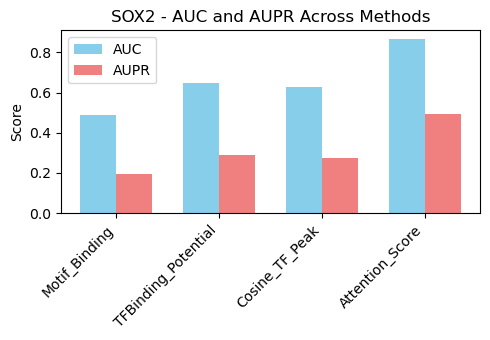

In [3]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score
import pickle

# Load RNA and ATAC data
rna_data = sc.read_h5ad('./Human_RNA.h5ad')
atac_data = sc.read_h5ad('./Human_ATAC_lsi.h5ad')

# Load attention score for TG-RE
df_attention = pd.read_csv('TG_RE_attscore.csv')
df_attention.columns = ['gene', 'peak', 'score']

# Load attention score for TF-RE
att_TF_RE = pd.read_csv('TF_RE_attscore.csv')
att_TF_RE.columns = ['Peaks', 'SOX2'] # 'SOX2' column stores the attentions score for the TF (SOX2) and the REs
att_TF_RE.index = att_TF_RE['Peaks']
att_TF_RE = att_TF_RE.drop(columns=['Peaks'])

# Load TF binding data for each TF in each peak derived from Homer
with open("tf_binding_all.pkl", "rb") as f:
    tf_binding = pd.read_pickle(f)

# Filter and create RE-TG matrix
rna_genes = rna_data.var_names
atac_peaks = atac_data.var_names
df_filtered = df_attention[df_attention['peak'].isin(atac_peaks) & df_attention['gene'].isin(rna_genes)]
re_tg_matrix = df_filtered.pivot_table(index="peak", columns="gene", values="score", fill_value=0)
re_tg_genes = re_tg_matrix.columns
re_tg_peaks = re_tg_matrix.index

# Subset data
rna_subset = rna_data[:, rna_data.var_names.isin(re_tg_genes)][:, re_tg_genes]
atac_subset = atac_data[:, atac_data.var_names.isin(re_tg_peaks)][:, re_tg_peaks]
atac_avg_subset = pd.DataFrame(atac_subset.X.mean(axis=0).A1, index=atac_subset.var_names, columns=["ATAC_avg"])

# TF binding subset
tfs_spmultiome = list(set(tf_binding.index) & set(rna_data.var_names))
tf_binding_sub = tf_binding.loc[tfs_spmultiome, atac_avg_subset.index.intersection(tf_binding.columns)]

# Functions 
def compute_cos(rna_data, atac_data):
    rna_matrix = rna_data.X.toarray() if hasattr(rna_data.X, "toarray") else rna_data.X
    atac_matrix = atac_data.X.toarray() if hasattr(atac_data.X, "toarray") else atac_data.X
    rna_norm = np.linalg.norm(rna_matrix, axis=0)
    atac_norm = np.linalg.norm(atac_matrix, axis=0)
    rna_norm[rna_norm == 0] = 1e-8
    atac_norm[atac_norm == 0] = 1e-8
    rna_matrix_normalized = rna_matrix / rna_norm
    atac_matrix_normalized = atac_matrix / atac_norm
    return pd.DataFrame(np.dot(rna_matrix_normalized.T, atac_matrix_normalized), 
                       index=rna_data.var_names, columns=atac_data.var_names)

def compute_auc_aupr(matrix, tf_name, true_targets):
    tf_scores = matrix.loc[tf_name].dropna()
    if tf_scores.empty or len(np.unique(tf_scores.index.isin(true_targets).astype(int))) < 2:
        return {"AUC": float('nan'), "AUPR": float('nan')}
    y_true = tf_scores.index.isin(true_targets).astype(int)
    y_scores = tf_scores.values
    return {"AUC": roc_auc_score(y_true, y_scores), "AUPR": average_precision_score(y_true, y_scores)}

# Compute Cosine similarity
rna_subset_tf = rna_data[:, tfs_spmultiome]
pcc_tf_re = compute_cos(rna_subset_tf, atac_subset)

# Process attention scores
common_peaks = att_TF_RE.index.intersection(re_tg_matrix.index)
att_TF_RE = att_TF_RE.loc[common_peaks].T
weights = re_tg_matrix.sum(axis=1)
weights = weights.loc[att_TF_RE.columns]
att_TF_RE1 = att_TF_RE * weights

# Analyze ChIP-seq data and compute AUC and AUPR
def analyze_chipseq(tf_name, filename, tf_binding_sub, tf_binding_sub_binary, tf_binding_sub_binary_opn, pcc_tf_re, att_TF_RE1, cutoff):
    chipseq_data = pd.read_csv(filename, sep='\t')
    chipseq_data.columns = ['RE', 'tissue', 'score']
    chipseq_data = chipseq_data.loc[chipseq_data['score'] > cutoff, :]
    true_targets = list(set(chipseq_data['RE'].unique()) & set(tf_binding_sub.columns))
    
    results = {
        "Motif_Binding": compute_auc_aupr(tf_binding_sub_binary, tf_name, true_targets),
        "TFBinding_Potential": compute_auc_aupr(tf_binding_sub_binary_opn, tf_name, true_targets),
        "Cosine_TF_Peak": compute_auc_aupr(pcc_tf_re, tf_name, true_targets),
        "Attention_Score": compute_auc_aupr(att_TF_RE1, tf_name, true_targets),
    }
    return results


row_vector = atac_avg_subset.T.squeeze()
tf_binding_sub_opn = pd.DataFrame([row_vector] * tf_binding_sub.shape[0], index=tf_binding_sub.index)
tf_binding_sub_binary = (tf_binding_sub > 0).astype(int)
tf_binding_sub_binary_opn = tf_binding_sub_binary * tf_binding_sub_opn

# Run analysis
# SOX2_cistrome.txt is a file download from http://cistrome.org/db/#/ and overlap the regions with the peaks in atac_data
tf_name = "SOX2"
filename = './SOX2_cistrome.txt'
SOX_result = analyze_chipseq(tf_name, filename, tf_binding_sub, tf_binding_sub_binary, tf_binding_sub_opn, pcc_tf_re, att_TF_RE1, cutoff=1)

# Plotting
auc_scores = {k: v["AUC"] for k, v in SOX_result.items()}
aupr_scores = {k: v["AUPR"] for k, v in SOX_result.items()}
methods = list(auc_scores.keys())
x = np.arange(len(methods))
width = 0.35

plt.figure(figsize=(5, 3.5))
plt.bar(x - width/2, [auc_scores[m] for m in methods], width, label='AUC', color='skyblue')
plt.bar(x + width/2, [aupr_scores[m] for m in methods], width, label='AUPR', color='lightcoral')
plt.ylabel('Score')
plt.title(f'{tf_name} - AUC and AUPR Across Methods')
plt.xticks(x, methods, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.savefig("SOX2_auc_aupr_comparison.pdf", format='pdf')
